<a href="https://colab.research.google.com/github/KarinaRmzG/Neuronal-Networks/blob/main/EVC_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importar bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Descargar el conjunto de datos de Kaggle y organizarlo en carpetas de entrenamiento, validación y prueba

# Crear generadores de imágenes para entrenamiento, validación y prueba
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train', target_size=(224, 224), batch_size=32, class_mode='binary')
validation_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation', target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test', target_size=(224, 224), batch_size=32, class_mode='binary')

Found 1843 images belonging to 2 classes.
Found 235 images belonging to 2 classes.
Found 437 images belonging to 2 classes.


In [4]:
# Cargar el modelo preentrenado VGG16 sin las capas densas
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [5]:
# Agregar capas densas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Compilar el modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Entrenar el modelo
model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
58/58 [==============================] - 555s 9s/step - loss: 0.6906 - accuracy: 0.5556 - val_loss: 0.6286 - val_accuracy: 0.6681
Epoch 2/10
58/58 [==============================] - 35s 602ms/step - loss: 0.6575 - accuracy: 0.6142 - val_loss: 0.6111 - val_accuracy: 0.6681
Epoch 3/10
58/58 [==============================] - 35s 601ms/step - loss: 0.6441 - accuracy: 0.6300 - val_loss: 0.6081 - val_accuracy: 0.6766
Epoch 4/10
58/58 [==============================] - 36s 619ms/step - loss: 0.6360 - accuracy: 0.6419 - val_loss: 0.6175 - val_accuracy: 0.7149
Epoch 5/10
58/58 [==============================] - 35s 604ms/step - loss: 0.6275 - accuracy: 0.6457 - val_loss: 0.6235 - val_accuracy: 0.6979
Epoch 6/10
58/58 [==============================] - 34s 582ms/step - loss: 0.6078 - accuracy: 0.6788 - val_loss: 0.5720 - val_accuracy: 0.7319
Epoch 7/10
58/58 [==============================] - 34s 585ms/step - loss: 0.5998 - accuracy: 0.6842 - val_loss: 0.5591 - val_accuracy: 0.7319
E

In [9]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

14/14 [==============================] - 255s 20s/step - loss: 0.5376 - accuracy: 0.7231
Test accuracy: 0.7231121063232422


In [12]:
# Obtener la matriz de confusión y el informe de clasificación
predictions = model.predict(test_generator)
y_pred = np.round(predictions)
y_true = test_generator.classes

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

14/14 [==============================] - 3s 178ms/step
[[268  39]
 [106  24]]
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       307
           1       0.38      0.18      0.25       130

    accuracy                           0.67       437
   macro avg       0.55      0.53      0.52       437
weighted avg       0.62      0.67      0.63       437



In [59]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model

def get_grad_cam(img_array, model, class_index, last_conv_layer_name, pred_layer_name):
    grad_model = Model(inputs=[model.input], outputs=[model.get_layer(last_conv_layer_name).output, model.get_layer(pred_layer_name).output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


In [56]:
# Seleccionar una imagen de prueba
img_path = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test/Normal/100 (15).jpg'

In [52]:
# Imprimir el resumen del modelo para ver los nombres de las capas
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [60]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

class_index = 0  # Índice de la clase de interés
last_conv_layer_name = 'block5_conv3'  # Nombre de la última capa convolucional
pred_layer_name = 'dense_1'  # Nombre de la capa de predicción final


# Cargar la imagen usando OpenCV
img = cv2.imread(img_path)

# Asegurarse de que la imagen tenga el tamaño correcto esperado por tu modelo (por ejemplo, (224, 224))
img = cv2.resize(img, (224, 224))

# Convertir la imagen a un array numpy
img_array = np.expand_dims(img, axis=0)
img_array = preprocess_input(img_array)

# Llamar a la función Grad-CAM con el array numpy de la imagen preprocesada
heatmap = get_grad_cam(img_array, model, class_index, last_conv_layer_name, pred_layer_name)

IndexError: ignored

In [61]:
# Superponer el Grad-CAM en la imagen original
img = image.load_img(img_path)
img = image.img_to_array(img)

heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img.astype('uint8'), 0.6, heatmap, 0.4, 0)

NameError: ignored

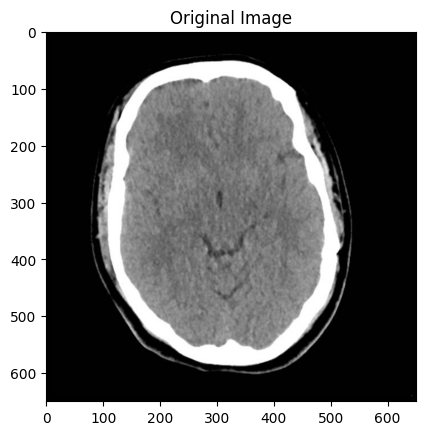

NameError: ignored

In [62]:
# Mostrar la imagen original, el Grad-CAM y la imagen superpuesta
plt.imshow(img.astype('uint8'))
plt.title('Original Image')
plt.show()

plt.imshow(heatmap)
plt.title('Grad-CAM')
plt.show()

plt.imshow(superimposed_img)
plt.title('Original Image with Grad-CAM')
plt.show()

In [63]:
# Obtener las predicciones en el conjunto de prueba
predictions = model.predict(test_generator)

# Convertir las probabilidades a etiquetas (0 o 1)
predicted_labels = np.round(predictions)

# Obtener las etiquetas reales del conjunto de prueba
true_labels = test_generator.classes

# Mostrar algunas predicciones
for i in range(10):  # Puedes ajustar el rango según sea necesario
    print(f"Sample {i + 1}: Predicted={predicted_labels[i]}, True={true_labels[i]}")

14/14 [==============================] - 2s 172ms/step
Sample 1: Predicted=[0.], True=0
Sample 2: Predicted=[0.], True=0
Sample 3: Predicted=[0.], True=0
Sample 4: Predicted=[1.], True=0
Sample 5: Predicted=[0.], True=0
Sample 6: Predicted=[0.], True=0
Sample 7: Predicted=[0.], True=0
Sample 8: Predicted=[0.], True=0
Sample 9: Predicted=[0.], True=0
Sample 10: Predicted=[0.], True=0


In [64]:
# Guardar el modelo en formato HDF5
model.save("modelo_EVC.h5")

# También puedes guardar el modelo en formato SavedModel
# model.save("ruta_del_directorio_saved_model")

# Ejemplo de cómo cargar el modelo después de guardarlo
# nuevo_modelo = tf.keras.models.load_model("modelo.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model("/content/modelo_EVC.h5")

# Cargar una nueva imagen para hacer una predicción
img_path = "/content/drive/MyDrive/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/075/brain/24.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, 0)  # Añadir una dimensión extra para el lote (batch)

# Realizar la predicción
predictions = loaded_model.predict(img_array)

# Interpretar la predicción
if predictions[0] > 0.5:
    prediction_label = "La imagen es un accidente cerebrovascular (stroke)."
else:
    prediction_label = "La imagen no es un accidente cerebrovascular (no stroke)."

# Mostrar la imagen y la predicción
plt.imshow(img)
plt.title(prediction_label)
plt.show()

OSError: ignored